# Predict

> A notebook to predict the test_set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.dataloaders import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import cv2
import numpy as np
import pandas as pd

pred_path = path.parent / "predictions"
pred_path.mkdir(parents=True, exist_ok=True)

In [3]:
print_competition_data(models_dir)

models/ResNet18-Unet-kaggle.pth
models/.ipynb_checkpoints
models/ResNet18-Classifier-kaggle.pth
models/ResNet34-Unet-256-stage5.pth
models/ResNet34-Unet-256-stage3.pth
models/ResNet34-Unet-128-stage2.5.pth


In [8]:
arch = resnet34
bs = 4 
dls = get_segmentation_dls_from_df(train_df=train_multi, bs=bs, size=(256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [9]:
segmentation_learner.validate()

(#3) [0.04104801267385483,0.7187527083045955,0.9185763597488403]

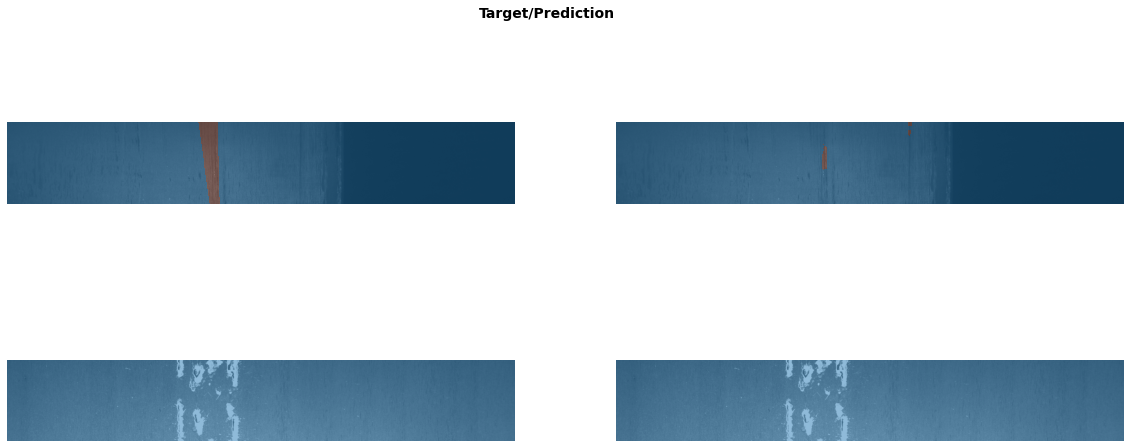

In [13]:
segmentation_learner.show_results(figsize=(20,8))

In [18]:
img_paths = get_image_files(test_path)
size_fold = 100
elems = len(img_paths)
folds = (elems // size_fold) + 1
threshold = 0.5
min_size = 3000
df_preds = []

In [19]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [20]:
for fold in range(folds):
    predictions = []
    
    start, end = fold*size_fold, (fold+1)*size_fold
    print(f"From {start} to {end} of {elems}")
    selected_imgs = img_paths[start:end]
    # get predictions
    test_dl = segmentation_learner.dls.test_dl(test_items=selected_imgs)
    pred_probs, _, pred_masks = segmentation_learner.get_preds(dl=test_dl, with_decoded=True)
    # get img names
    img_names = L(test_dl.items).map(lambda x: x.name)
    # calc the RLEs
    for num_pred, t_pred in enumerate(pred_probs): # img in bs
        np_pred = t_pred.numpy()
        # iterate through class_id without class_id 0
        for class_id, prob in enumerate(np_pred[1:]): 
            pred, num = post_process(prob, threshold, min_size)
            rle = mask2rle(pred)
            name = img_names[num_pred] + f"_{class_id+1}"
            predictions.append([name, rle])
            
    tmp_df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
    df_preds.append(tmp_df)

    torch.cuda.empty_cache()
    del predictions

From 0 to 100 of 5506


/storage/steel_segmentation/steel_segmentation/models/metrics.py:45: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


From 100 to 200 of 5506


From 200 to 300 of 5506


From 300 to 400 of 5506


From 400 to 500 of 5506


From 500 to 600 of 5506


From 600 to 700 of 5506


From 700 to 800 of 5506


From 800 to 900 of 5506


From 900 to 1000 of 5506


From 1000 to 1100 of 5506


From 1100 to 1200 of 5506


From 1200 to 1300 of 5506


From 1300 to 1400 of 5506


From 1400 to 1500 of 5506


From 1500 to 1600 of 5506


From 1600 to 1700 of 5506


From 1700 to 1800 of 5506


From 1800 to 1900 of 5506


From 1900 to 2000 of 5506


From 2000 to 2100 of 5506


From 2100 to 2200 of 5506


From 2200 to 2300 of 5506


From 2300 to 2400 of 5506


From 2400 to 2500 of 5506


From 2500 to 2600 of 5506


From 2600 to 2700 of 5506


From 2700 to 2800 of 5506


From 2800 to 2900 of 5506


From 2900 to 3000 of 5506


From 3000 to 3100 of 5506


From 3100 to 3200 of 5506


From 3200 to 3300 of 5506


From 3300 to 3400 of 5506


From 3400 to 3500 of 5506


From 3500 to 3600 of 5506


From 3600 to 3700 of 5506


From 3700 to 3800 of 5506


From 3800 to 3900 of 5506


From 3900 to 4000 of 5506


From 4000 to 4100 of 5506


From 4100 to 4200 of 5506


From 4200 to 4300 of 5506


From 4300 to 4400 of 5506


From 4400 to 4500 of 5506


From 4500 to 4600 of 5506


From 4600 to 4700 of 5506


From 4700 to 4800 of 5506


From 4800 to 4900 of 5506


From 4900 to 5000 of 5506


From 5000 to 5100 of 5506


From 5100 to 5200 of 5506


From 5200 to 5300 of 5506


From 5300 to 5400 of 5506


From 5400 to 5500 of 5506


From 5500 to 5600 of 5506


In [22]:
df = pd.concat(df_preds, axis=0, ignore_index=True)
df.fillna("", inplace=True)
df.to_csv(path/"resnet34s5_fastai_sub.csv", index=False)